In [1]:
#Загружаем библиотеки
import seaborn as sns
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed

from keras_tuner.tuners import RandomSearch

from tensorflow.keras.callbacks import EarlyStopping

In [2]:

#функция считывает названия параметров из файла и приводит в вид для считывания

def process_excel_headers(excel_file, sheet_name):
  """
  Обрабатывает заголовки столбцов в Excel-файле.

  Args:
      excel_file (str): Путь к Excel-файлу.
      sheet_name (str): Название листа в Excel-файле.

  Returns:
      tuple: Кортеж из трех списков:
          - Исходные заголовки столбцов.
          - Заголовки столбцов без первого элемента.
          - Список обновленных заголовков с префиксом и суффиксом "ssx".
  """
  df = pd.read_excel(excel_file, sheet_name=sheet_name)

  fileheaders = list(df.columns)
  fileheaders  = [header.lower() for header in fileheaders]
  headerskey = fileheaders[1:]
  updated_list = ["ssx" + item for item in headerskey]
  jsonstring = str(updated_list)
  jsonstring = jsonstring.replace("'", '"')    
  return fileheaders, headerskey, updated_list, jsonstring
excel_file = 'LearningMaterials.xlsx'
sheet_name = 'BasicDatasetSteamTurbine'
fileheaders, headerskey, updated_list, jsonstring = process_excel_headers(excel_file, sheet_name)

In [3]:
#определяем размер будущего графика и убираем сетку (если False)
mpl.rcParams['figure.figsize'] = (8, 12)
mpl.rcParams['axes.grid'] = False

In [4]:
#считывания данных из файла
df = pd.read_csv('mix_data.csv')

In [5]:
#проверяем корректность подгружаемых данных путем отображения первых 5 записей
df.head(15)

,ssx10maa01cp001,ssx10maa01ct001,ssx10lbg40cp920,ssx10mag10cp930,ssx10lca10ct001,ssx10lbg11cp920,ssx10lca20cf001,ssx10pab10cf001,ssx10pab30cf001,ssx10pab10ct001,ssx10pab30ct001,ssx10pab20ct001,ssx10pab60ct001,ssxtg_2ce003,DateTime
0,10.270994,43.841614,30.307894,54.954401,44.890861,3495.188005,0.506049,104.016115,44.395362,29.812344,6.222020,202.072078,489.015021,3480.194382,2024-07-09 16:35:27.154034
1,10.270967,43.841737,30.307861,54.954136,44.893248,3495.188363,0.506161,104.020445,44.395335,29.812302,6.222045,201.087811,489.021920,3480.194742,2024-07-09 16:35:27.892078
2,10.270935,43.841874,30.307811,54.955067,44.896981,3495.188955,0.506312,104.022178,44.395294,29.812239,6.222217,200.931855,489.029908,3480.195333,2024-07-09 16:35:28.626439
3,10.270975,43.841938,30.307778,54.956281,44.899568,3495.189461,0.506403,104.022544,44.395265,29.812197,6.222287,200.582161,489.031031,3480.195833,2024-07-09 16:35:29.358950
4,10.271030,43.842055,30.307732,54.957288,44.903360,3495.189674,0.506525,104.022352,44.395246,29.812137,6.222305,199.449976,489.031465,3480.196050,2024-07-09 16:35:30.086347
5,10.271161,43.842128,30.307696,54.956425,44.906357,3495.189877,0.506634,104.013671,44.395232,29.812091,6.222287,199.048239,489.031880,3480.196252,2024-07-09 16:35:30.817699
6,10.271151,43.842240,30.307649,54.954576,44.910397,3495.189935,0.506803,104.015534,44.395233,29.812032,6.222316,197.995677,489.034112,3480.196309,2024-07-09 16:35:31.551183
7,10.271234,43.842324,30.307614,54.956378,44.913573,3495.189972,0.506930,104.020553,44.395240,29.811986,6.222311,197.357152,489.034247,3480.196344,2024-07-09 16:35:32.287
8,10.271241,43.842397,30.307581,54.956281,44.916568,3495.189982,0.507036,104.022761,44.395250,29.811944,6.222327,196.865168,489.035224,3480.196354,2024-07-09 16:35:33.019100
9,10.271234,43.842473,30.307531,54.958282,44.921169,3495.190154,0.507185,104.023569,44.395260,29.811881,6.222363,196.689653,489.037085,3480.196511,2024-07-09 16:35:33.752175


In [10]:
#удаление строк с пробелами

import pandas as pd
0
def delete_null_strings(filepath):
    df = pd.read_csv(filepath)  # Чтение файла CSV
    df.dropna(inplace=True)  # Удаление строк с пустыми значениями
    df.to_csv('cached_data_5_1.csv', index=False)  # Сохранение изменений обратно в файл

# Пример использования:
delete_null_strings('cached_data_5.csv')


In [6]:
#делим датасет на слайсы для построения релевантного графика
#df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M')
df = df[::]
#проверяем отображение колонок
df.columns

Index(['ssx10maa01cp001', 'ssx10maa01ct001', 'ssx10lbg40cp920',
       'ssx10mag10cp930', 'ssx10lca10ct001', 'ssx10lbg11cp920',
       'ssx10lca20cf001', 'ssx10pab10cf001', 'ssx10pab30cf001',
       'ssx10pab10ct001', 'ssx10pab30ct001', 'ssx10pab20ct001',
       'ssx10pab60ct001', 'ssxtg_2ce003', 'DateTime'],
      dtype='object')

In [7]:
#подгоняем формат даты для дальнейших манипуляций
# Проверяем, есть ли столбец 'Date Time' в датафрейме
if 'DateTime' in df.columns:
    date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
else:
    print("Столбец 'DateTime' отсутствует в датафрейме.")

C:\Users\PC\AppData\Local\Temp\ipykernel_20100\367553521.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)


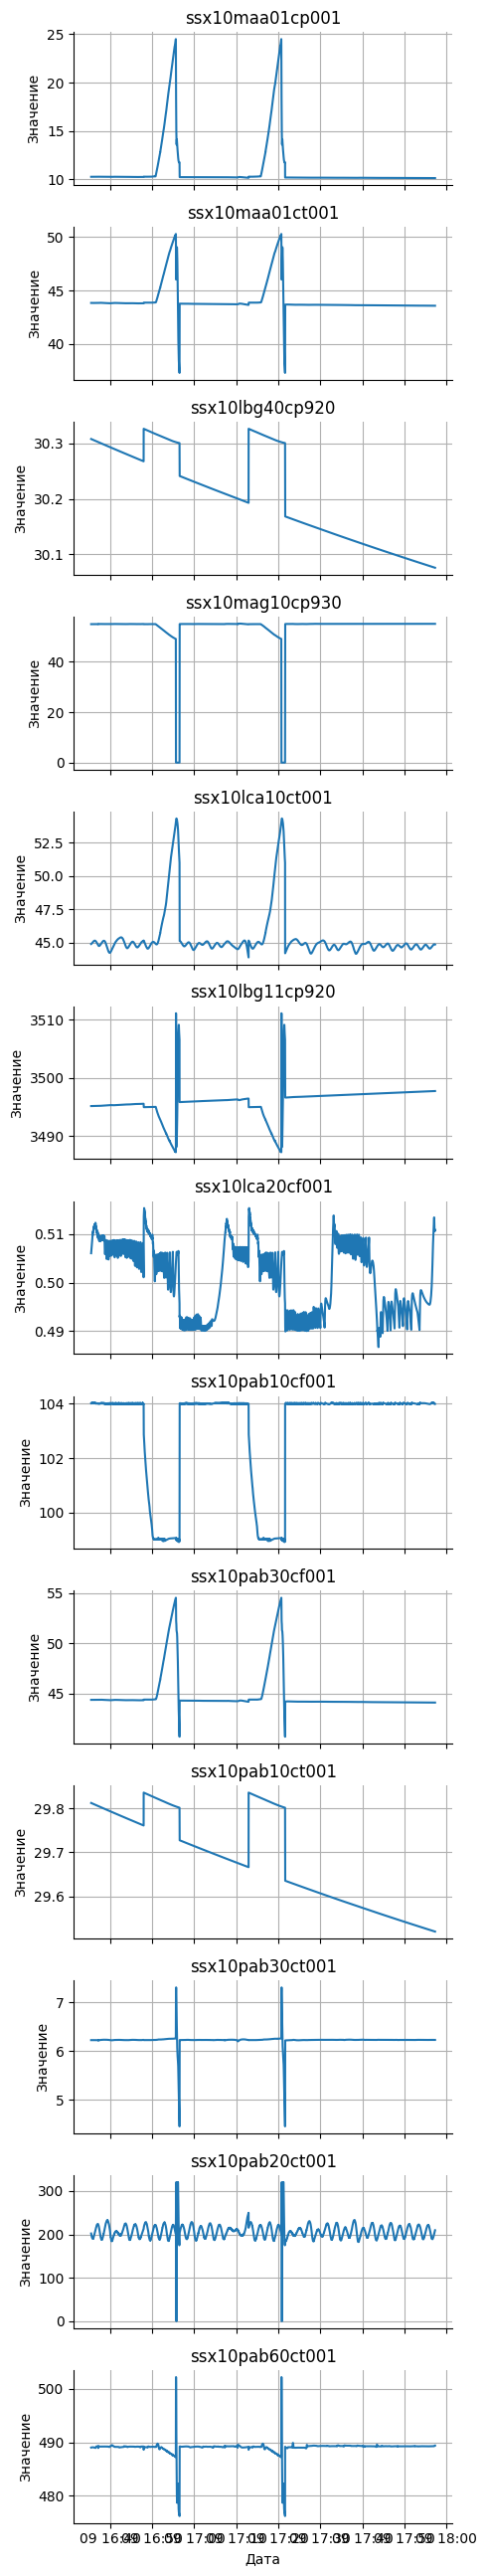

In [8]:
#с этого момента начинается часть для одноразмерного предсказания временных рядов

#строим графики (в моем случае для всех критериев)

# Строим графики
plot_cols = ['10MAA01CP001', '10MAA01CT001', '10LBG40CP920', '10MAG10CP930',
               '10LCA10CT001', '10LBG11CP920', '10LCA20CF001', '10PAB10CF001',
               '10PAB30CF001', '10PAB10CT001', '10PAB30CT001', '10PAB20CT001',
               '10PAB60CT001']

plot_cols  = [header.lower() for header in fileheaders]

plot_cols = ["ssx" + item for item in headerskey]
plot_features = df[plot_cols]
plot_features.index = date_time[:]

# Делим графики на подграфики
fig, axes = plt.subplots(len(plot_cols), 1, figsize=(5, 2 * len(plot_cols)))

# Цикл для оформления каждого подграфика
for i, col in enumerate(plot_cols):
    axes[i].plot(plot_features[col])
    axes[i].set_title(col)  # Добавили заголовок для каждого графика
    axes[i].grid(True) 
    axes[i].spines['top'].set_visible(False)  # Убираем верхнюю рамку
    axes[i].spines['right'].set_visible(False)  # Убираем правую рамку
    axes[i].set_ylabel("Значение")  #  Добавили ось Y


#  Отключаем ненужные оси 
for ax in axes[:-1]:
    ax.set_xlabel("")  # Отключаем ось X для всех подграфиков, кроме последнего
    ax.tick_params(labelbottom=False)

# Устанавливаем общую ось X для всех подграфиков
plt.xlabel("Дата")

# Отображаем график
plt.tight_layout()  #  Улучшаем расположение элементов на графике
plt.show() 
 

In [32]:
type(plot_cols)

list

In [53]:
#удаление n-го элемента массива (если потом нужно будет удалять конкретный столбец)

import numpy as np

# Создание массива
arr = np.array(['frg', '4, 5, 6', '7, 8, 9'])

# Удаление второго столбца (с индексом 1)
arr = np.delete(arr, 1)

arr
 

array(['frg', '7, 8, 9'], dtype='<U7')

In [9]:
df[plot_cols].dtypes

ssx10maa01cp001    float64
ssx10maa01ct001    float64
ssx10lbg40cp920    float64
ssx10mag10cp930    float64
ssx10lca10ct001    float64
ssx10lbg11cp920    float64
ssx10lca20cf001    float64
ssx10pab10cf001    float64
ssx10pab30cf001    float64
ssx10pab10ct001    float64
ssx10pab30ct001    float64
ssx10pab20ct001    float64
ssx10pab60ct001    float64
dtype: object

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ssx10maa01cp001,6492.0,11.097844,2.708385,10.137516,10.171383,10.219582,10.270346,24.503663
ssx10maa01ct001,6492.0,44.134405,1.474886,37.292236,43.638514,43.736371,43.837404,50.296996
ssx10lbg40cp920,6492.0,30.207075,0.083367,30.075909,30.128280,30.208910,30.298384,30.326340
ssx10mag10cp930,6492.0,53.428857,8.136593,0.000000,54.974027,55.018851,55.066900,55.172674
ssx10lca10ct001,6492.0,45.438407,1.987279,43.885765,44.673834,44.869943,45.051256,54.302854
ssx10lbg11cp920,6492.0,3495.853324,2.538095,3487.265934,3495.332029,3496.231886,3497.170193,3511.102963
ssx10lca20cf001,6492.0,0.500925,0.006996,0.486702,0.493770,0.502645,0.506677,0.515357
ssx10pab10cf001,6492.0,103.031026,1.906511,98.930169,103.977278,103.992925,104.012708,104.026453
ssx10pab30cf001,6492.0,44.968426,2.143431,40.737670,44.191557,44.288785,44.392227,54.517678
ssx10pab10ct001,6492.0,29.684608,0.105342,29.519568,29.584986,29.686467,29.800194,29.835967


In [21]:
TOTAL = df.shape[0]
TRAIN_VAL = int(TOTAL * 0.7)
VAL_TEST = int(TOTAL * 0.9)


my_scaler = MinMaxScaler()
df_scaled = my_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)
train_df = df[:TRAIN_VAL]
val_df = df[TRAIN_VAL:VAL_TEST]
test_df = df[VAL_TEST:]

print("Training dataset shape:", train_df.shape)
print("Validation dataset shape:", val_df.shape)
print("Test dataset shape:", test_df.shape)

Training dataset shape: (4544, 14)
Validation dataset shape: (1298, 14)
Test dataset shape: (650, 14)


C:\Users\PC\AppData\Local\Temp\ipykernel_20100\2666552140.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


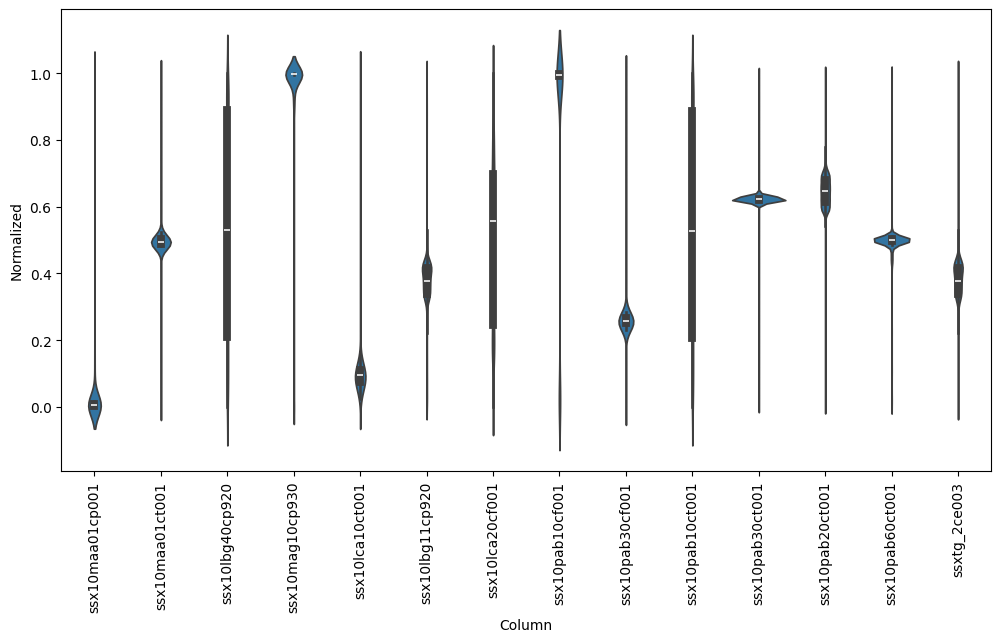

In [22]:
df_std = df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [23]:
INPUT_TIMES = 72
OUTPUT_TIMES = 24
# Single step dataset preparation
def multiStepSampler(df, window_input=INPUT_TIMES, window_output=OUTPUT_TIMES):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window_input - window_output):
		xRes.append(df.iloc[i:i + window_input].values)
		yRes.append(df.iloc[i + window_input:i + window_input + window_output].values)
	return np.array(xRes), np.array(yRes)

In [24]:
# Dataset splitting
(X_train, y_train) = multiStepSampler(train_df)
(X_val, y_val) = multiStepSampler(val_df)
(X_test, y_test) = multiStepSampler(test_df)

In [29]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1] * y_train.shape[2],
                                            activation='linear'),
    tf.keras.layers.Reshape([y_train.shape[1], y_train.shape[2]])
])
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=[tf.keras.metrics.MeanAbsoluteError()])



history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    shuffle=False
)

lstm_model.summary()


Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0892 - mean_absolute_error: 0.2010 - val_loss: 0.0132 - val_mean_absolute_error: 0.0607
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0351 - mean_absolute_error: 0.1201 - val_loss: 0.0136 - val_mean_absolute_error: 0.0574
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0365 - mean_absolute_error: 0.1202 - val_loss: 0.0147 - val_mean_absolute_error: 0.0618
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0423 - mean_absolute_error: 0.1224 - val_loss: 0.0137 - val_mean_absolute_error: 0.0575
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0293 - mean_absolute_error: 0.1057 - val_loss: 0.0118 - val_mean_absolute_error: 0.0491
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0237 - mean_absolute_error: 0.0968 - val_loss: 0.0119 - val_mean_absolute_error: 0.0499
Epoch 7/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0196 - mean_absolute_error: 0.0

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 100)            │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 336)            │        33,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 24, 14)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,810 (936.76 KB)

 Trainable params: 79,936 (312.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 159,874 (624.51 KB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


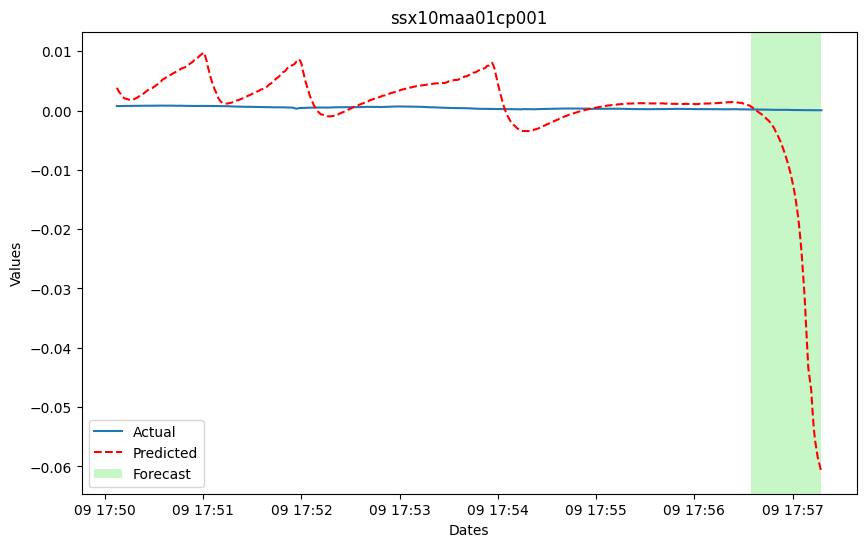

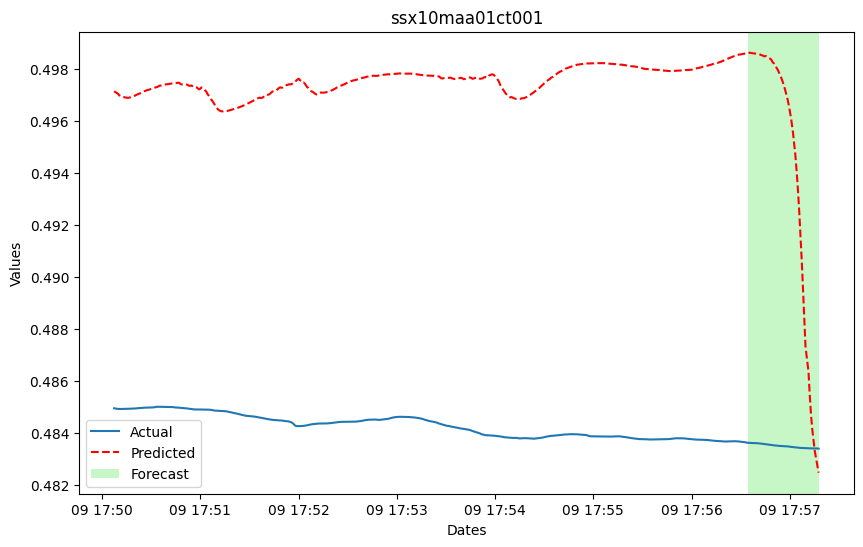

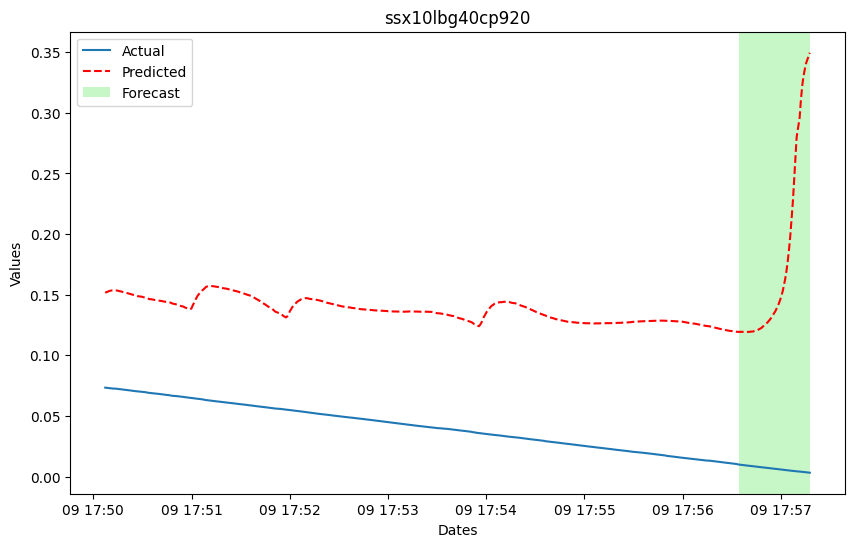

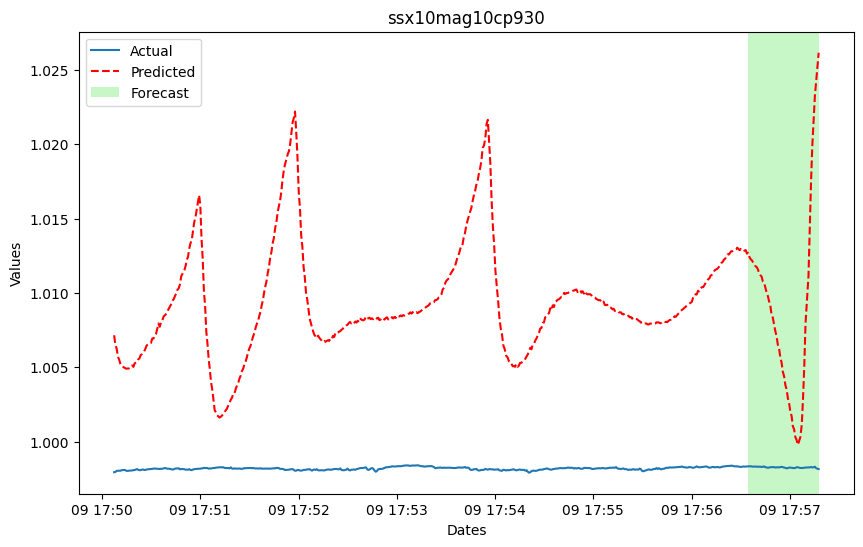

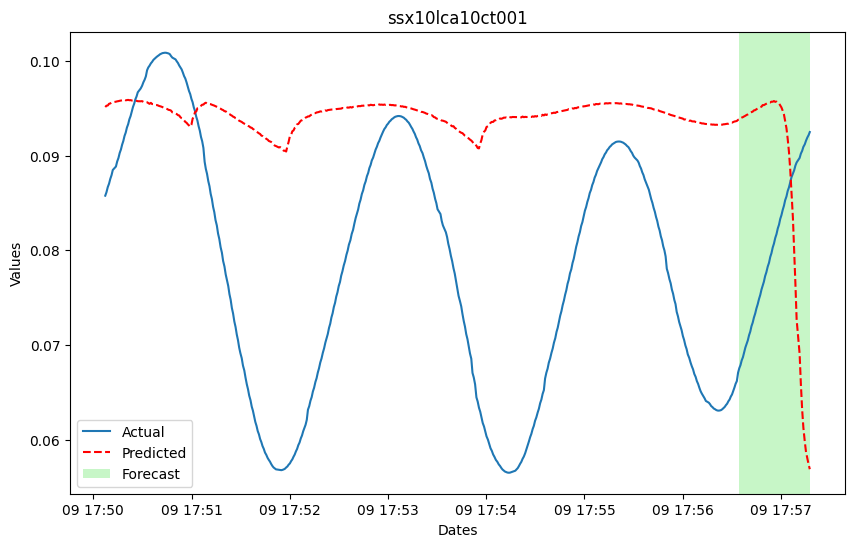

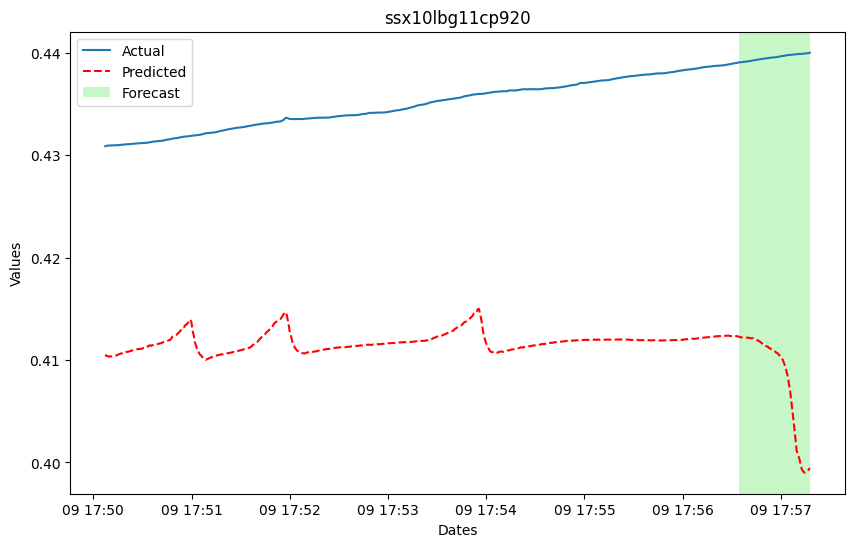

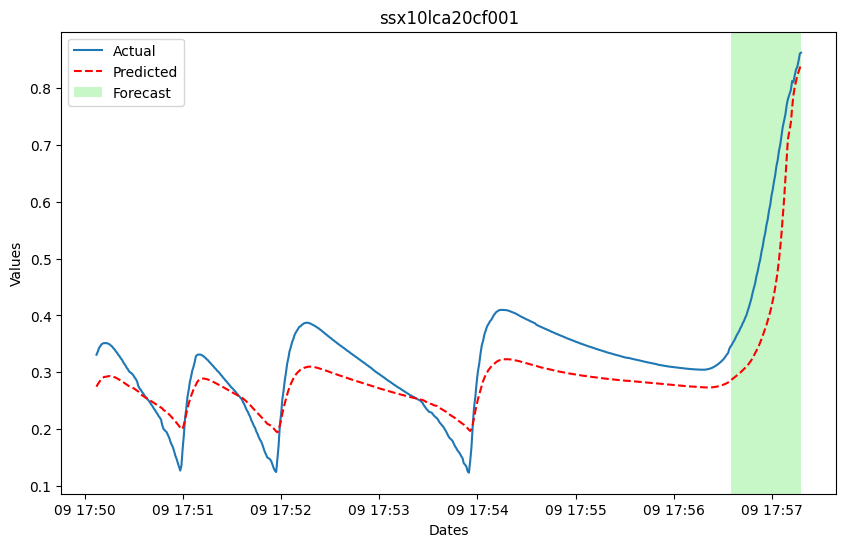

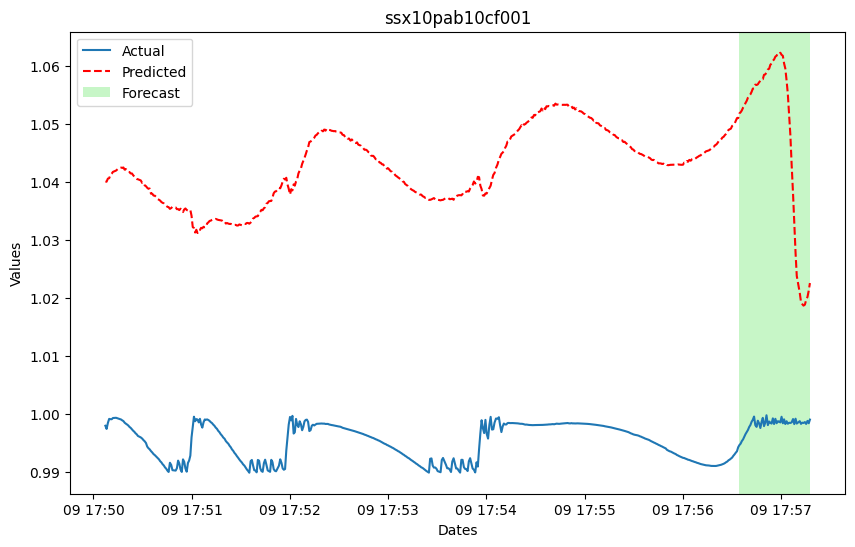

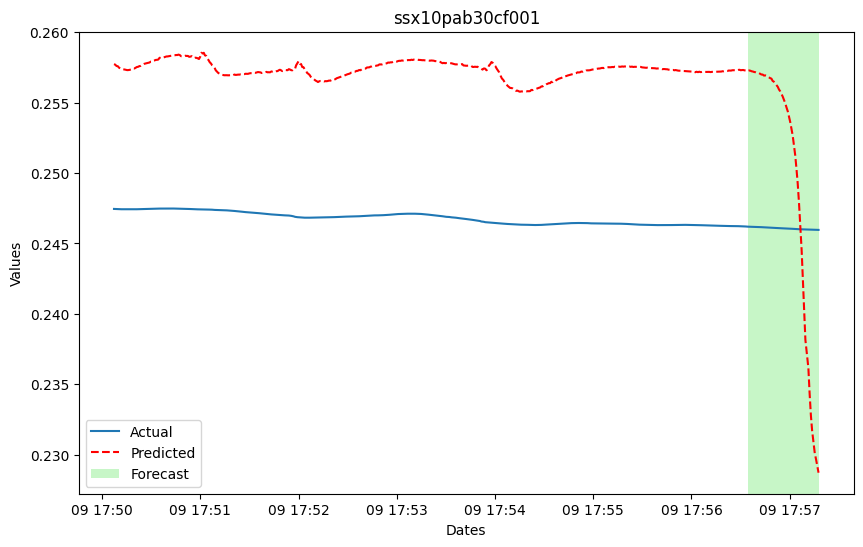

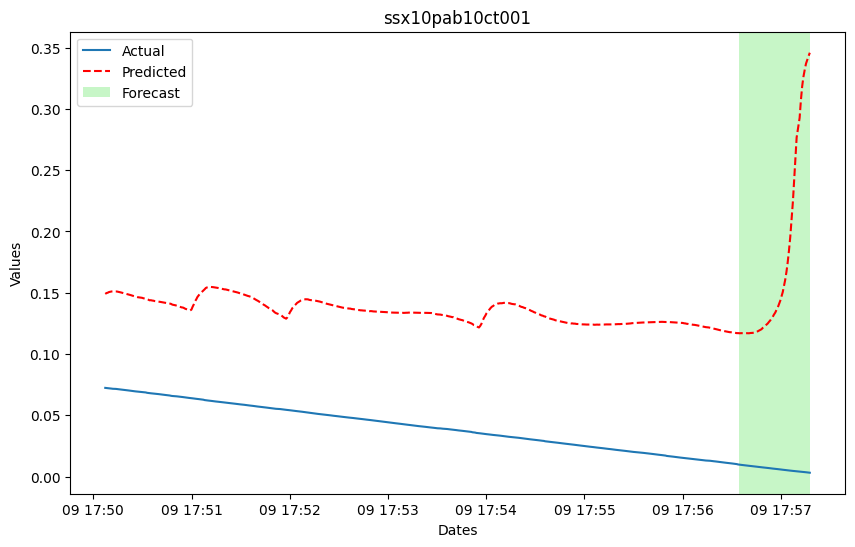

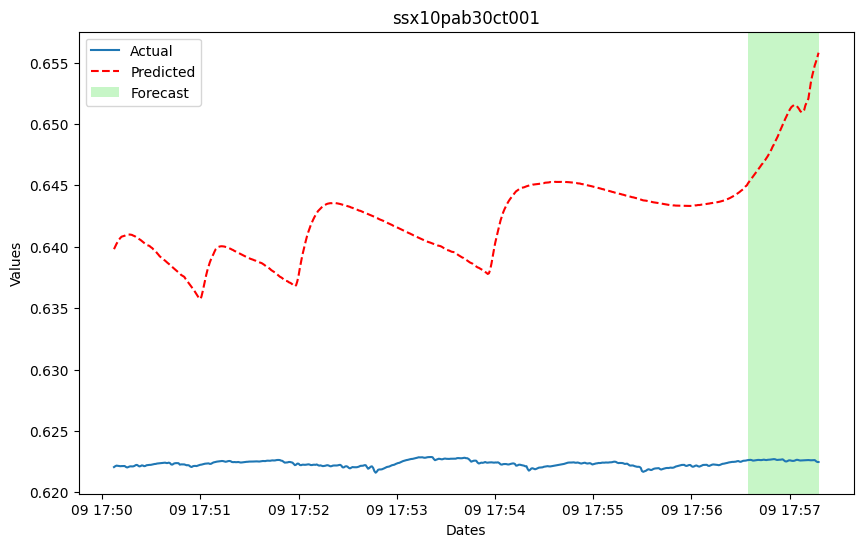

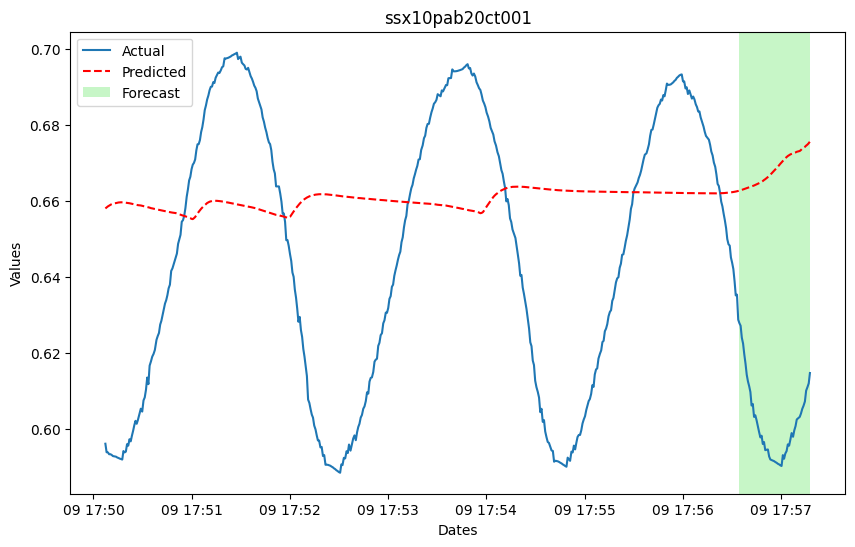

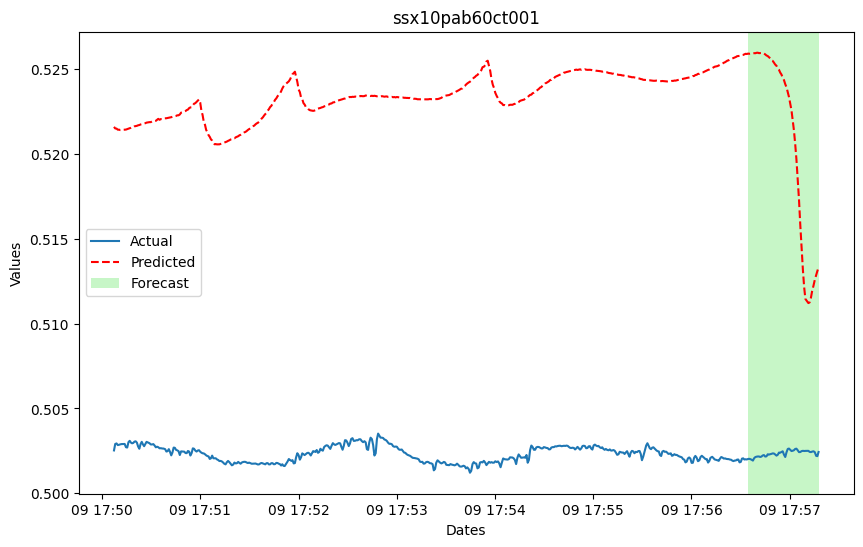

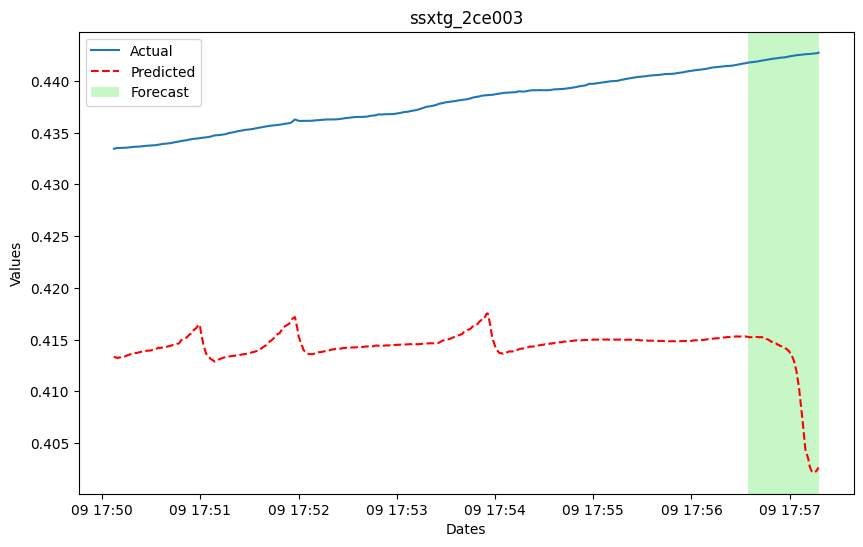

In [68]:
# Forecast Plot with Dates on X-axis
predicted_values = lstm_model.predict(X_test)

d_pred = pd.DataFrame(predicted_values[:, 0], columns=df.columns)
d_pred.index = date_time[-len(d_pred):]
d_test = pd.DataFrame(y_test[:, 0], columns=df.columns)
d_test.index = date_time[-len(d_test):]
sensors_names = list(df)[:14]

for ind, sensor in enumerate(sensors_names):
  fig, ax = plt.subplots(figsize=(10, 6))

  # Plot the actual values
  plt.plot(d_test[sensor], label='Actual')

  # Plot predicted values with a dashed line
  plt.plot(d_pred[sensor], label='Predicted', color='r', linestyle='--')

  # Highlight the forecasted portion with a different color
  plt.axvspan(d_test.index[int(len(d_test) * 0.9)], d_test.index[len(d_test) - 1], facecolor='lightgreen', alpha=0.5, label='Forecast')

  plt.title(sensor)
  plt.xlabel('Dates')
  plt.ylabel('Values')
  ax.legend()


  

In [67]:
 # Forecast Plot with Dates on X-axis
predicted_values = lstm_model.predict(X_test)

# Inverse transform predicted values to get real values
predicted_values_real = my_scaler.inverse_transform(predicted_values.reshape(-1, predicted_values.shape[-1]))

# Create DataFrames for predicted and actual values
d_pred_real = pd.DataFrame(predicted_values_real, columns=df.columns)  # Use all columns
d_pred_real.index = date_time[-len(d_pred_real):]
d_test = pd.DataFrame(y_test[:, 0], columns=df.columns)
d_test.index = date_time[-len(d_test):]
sensors_names = list(df)[:14]

# Plot the forecasts
sensors_names = list(df)[:14]
for ind, sensor in enumerate(sensors_names):
  fig, ax = plt.subplots(figsize=(10, 6))

  # Plot actual values
  plt.plot(d_test[sensor], label='Actual')

  # Plot predicted values with a dashed line
  plt.plot(d_pred_real[sensor], label='Predicted', color='r', linestyle='--')

  # Highlight the forecasted portion
  plt.axvspan(d_test.index[int(len(d_test) * 0.9)], d_test.index[len(d_test) - 1], facecolor='lightgreen', alpha=0.5, label='Forecast')

  plt.title(sensor)
  plt.xlabel('Dates')
  plt.ylabel('Values')
  ax.legend()
  plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


ValueError: Length mismatch: Expected axis has 13296 elements, new values have 554 elements

In [59]:
predicted_values_real
d_pred

,ssx10maa01cp001,ssx10maa01ct001,ssx10lbg40cp920,ssx10mag10cp930,ssx10lca10ct001,ssx10lbg11cp920,ssx10lca20cf001,ssx10pab10cf001,ssx10pab30cf001,ssx10pab10ct001,ssx10pab30ct001,ssx10pab20ct001,ssx10pab60ct001,ssxtg_2ce003
DateTime,,,,,,,,,,,,,,
2024-07-09 17:50:07.282880,0.003824,0.497128,0.151492,1.007154,0.095130,0.410525,0.274629,1.040047,0.257731,0.149031,0.639806,0.658049,0.521593,0.413391
2024-07-09 17:50:08.023789,0.003461,0.497100,0.152164,1.006491,0.095274,0.410399,0.278830,1.040067,0.257693,0.149704,0.640020,0.658315,0.521497,0.413280
2024-07-09 17:50:08.819423,0.003062,0.497072,0.152490,1.006265,0.095295,0.410384,0.282196,1.040600,0.257598,0.150028,0.640239,0.658590,0.521490,0.413278
2024-07-09 17:50:09.598195,0.002806,0.497039,0.153029,1.005709,0.095474,0.410316,0.285500,1.040659,0.257583,0.150567,0.640415,0.658797,0.521424,0.413223
2024-07-09 17:50:10.367031,0.002463,0.496980,0.153271,1.005509,0.095514,0.410363,0.288061,1.041210,0.257477,0.150805,0.640587,0.659021,0.521427,0.413282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-09 17:57:14.570112,-0.057087,0.483683,0.335840,1.021694,0.059804,0.398996,0.812321,1.018872,0.230833,0.332184,0.654343,0.674275,0.512245,0.402146
2024-07-09 17:57:15.330013,-0.058404,0.483280,0.340720,1.023266,0.058692,0.399051,0.822018,1.019687,0.230104,0.337023,0.654776,0.674601,0.512574,0.402207
2024-07-09 17:57:16.159440,-0.059297,0.483002,0.344048,1.024290,0.057994,0.399131,0.828714,1.020212,0.229633,0.340328,0.655103,0.674891,0.512860,0.402290


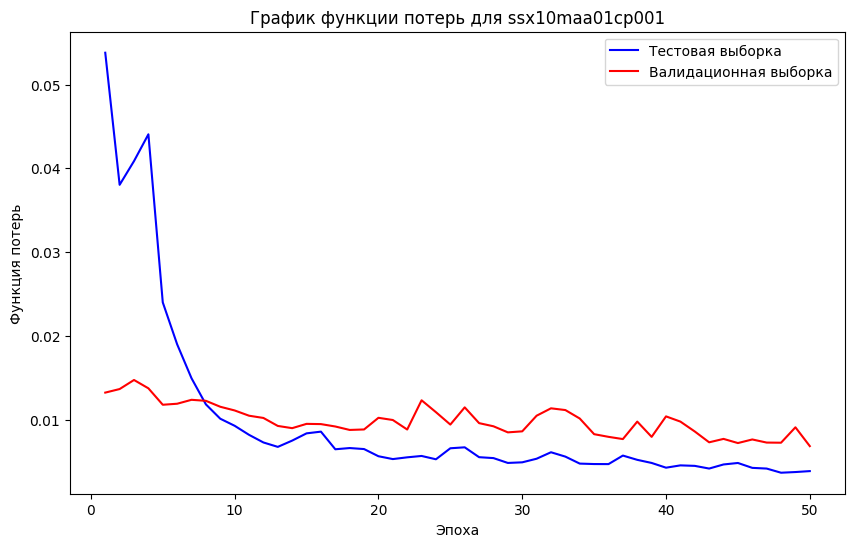

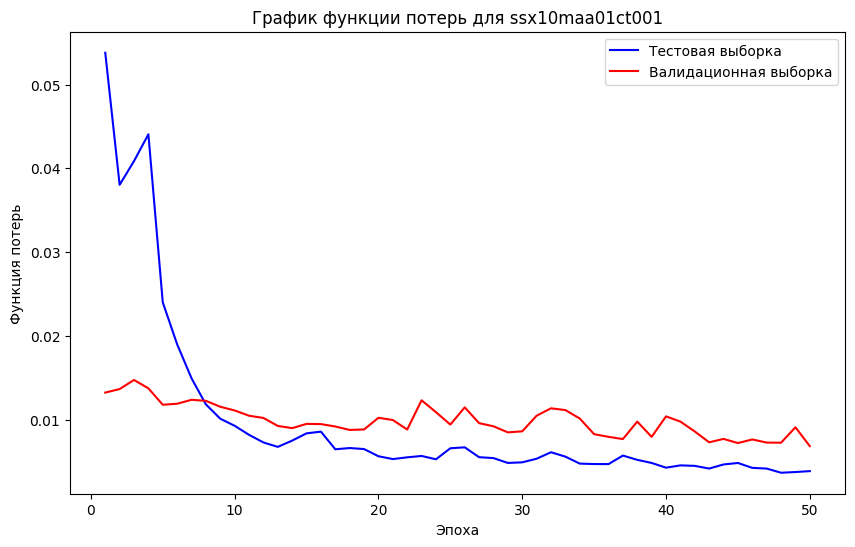

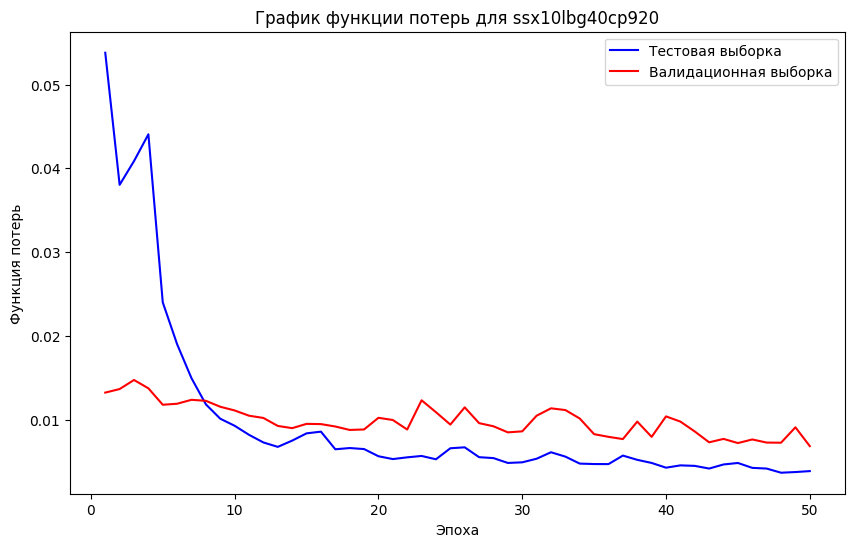

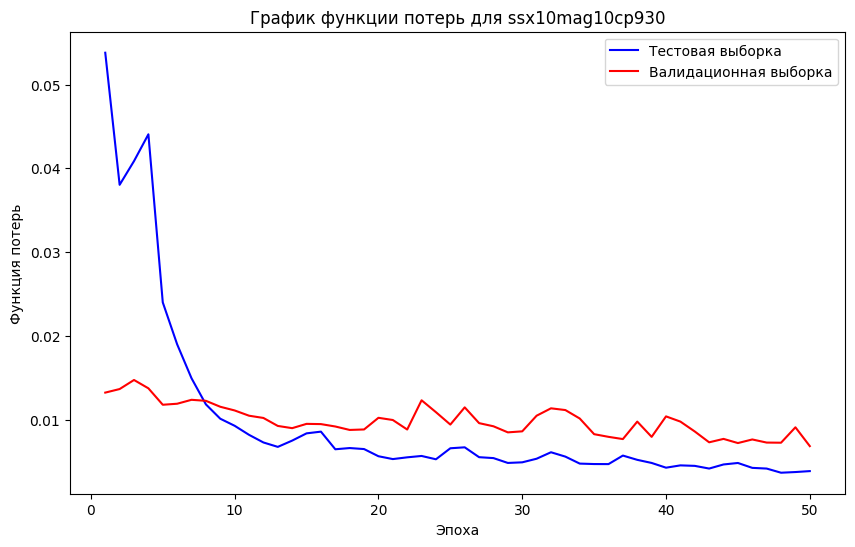

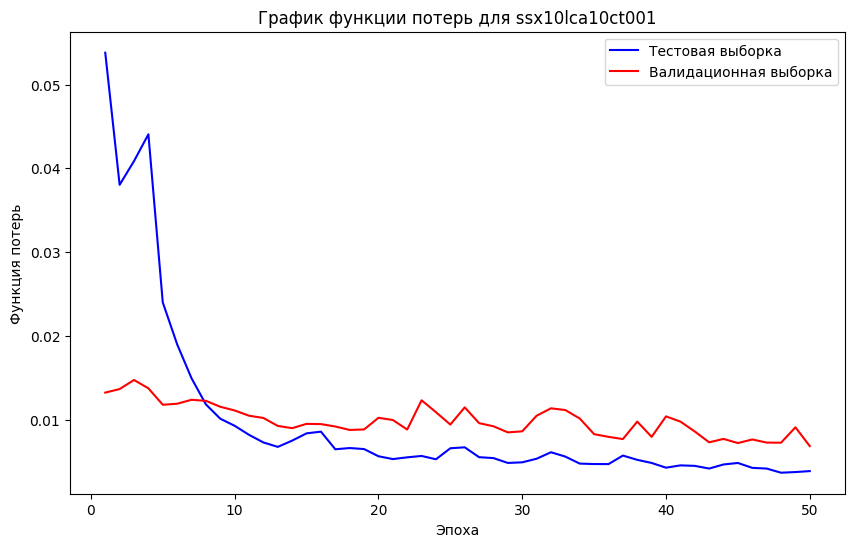

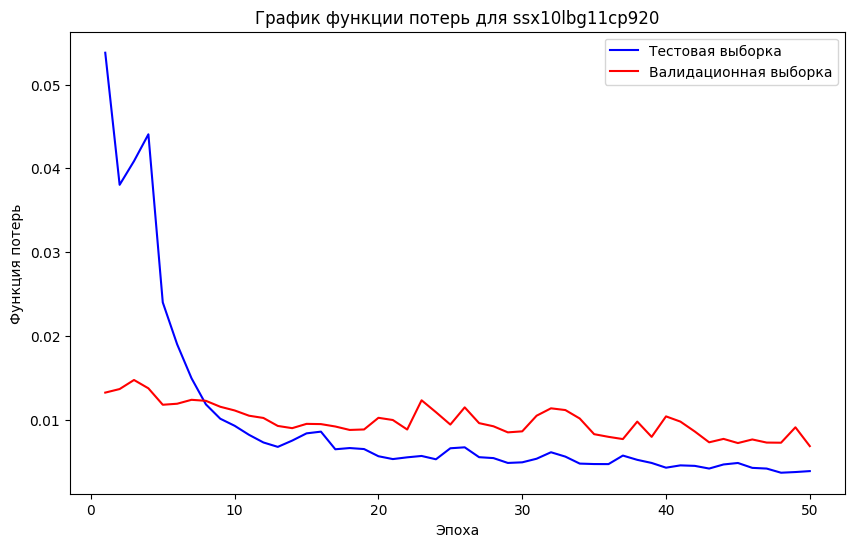

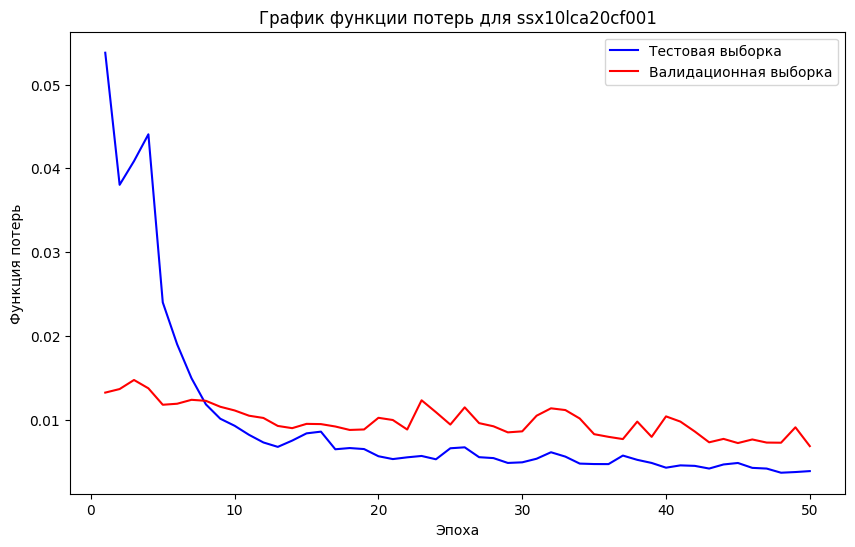

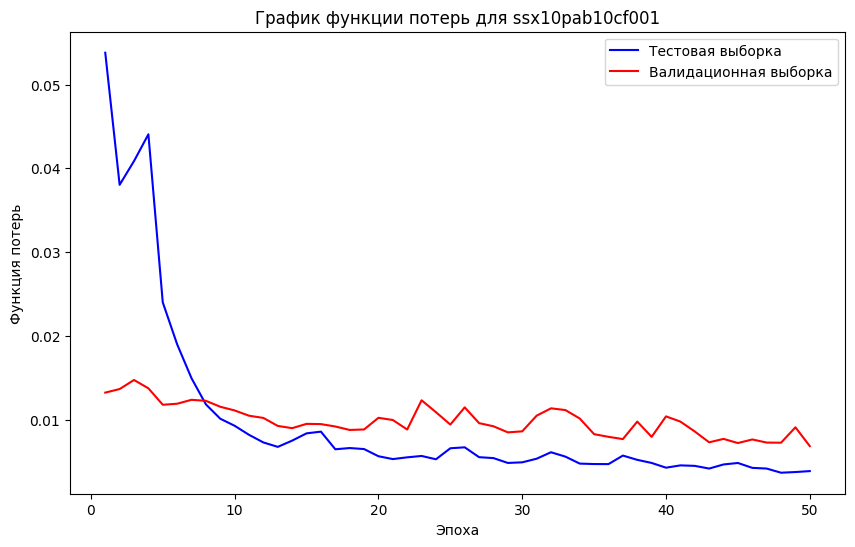

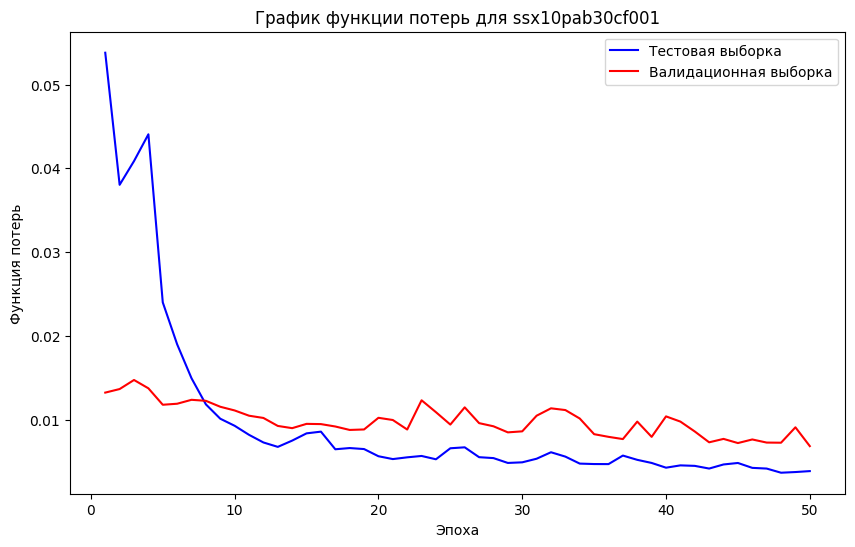

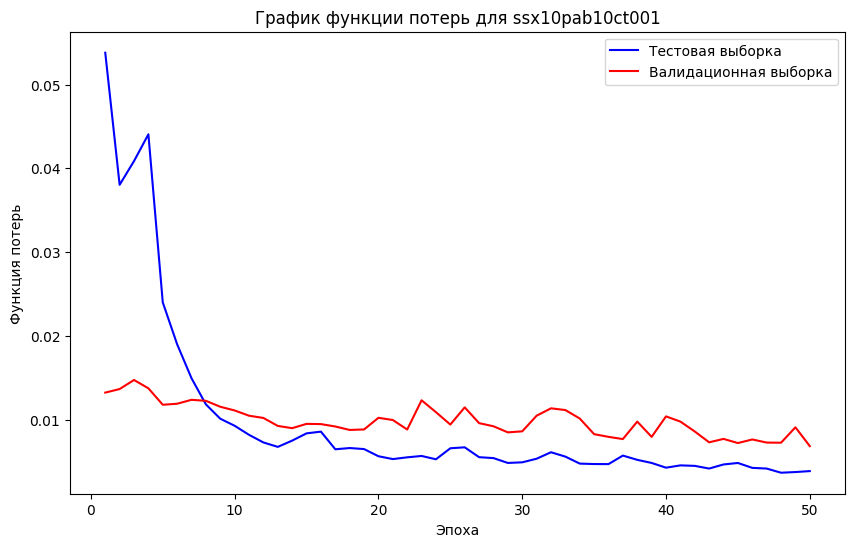

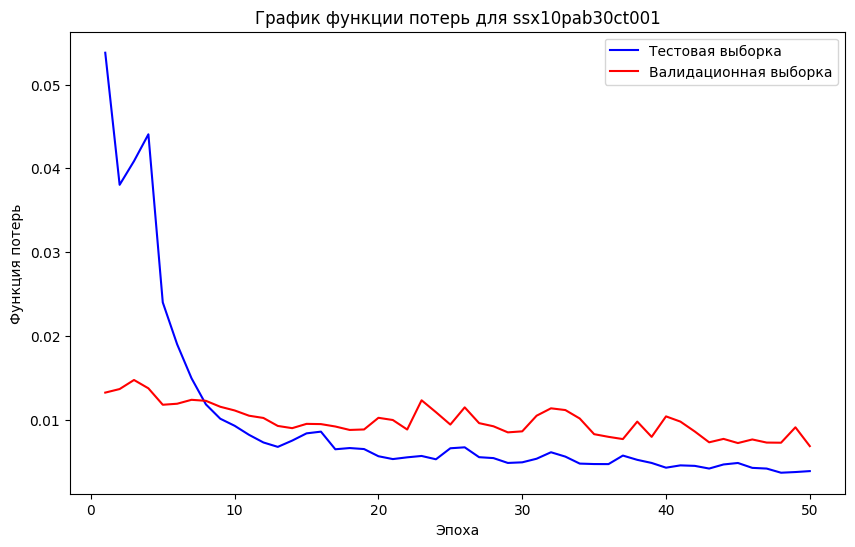

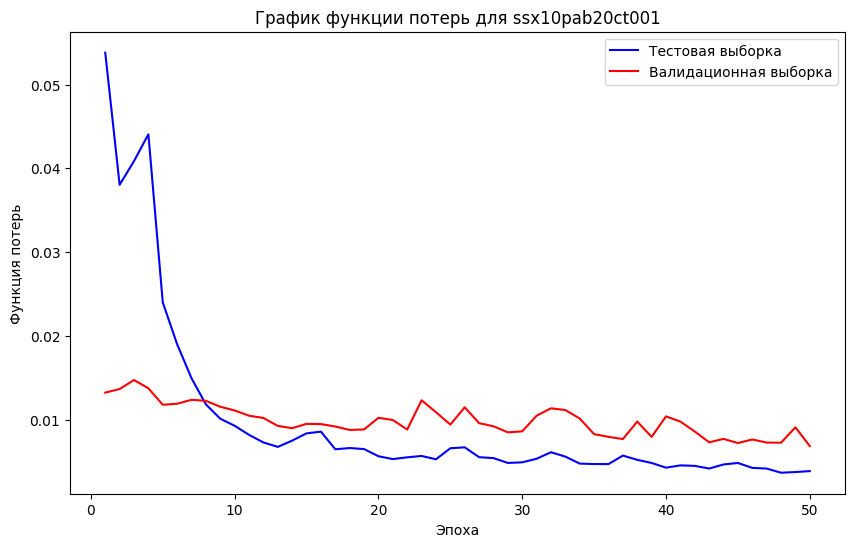

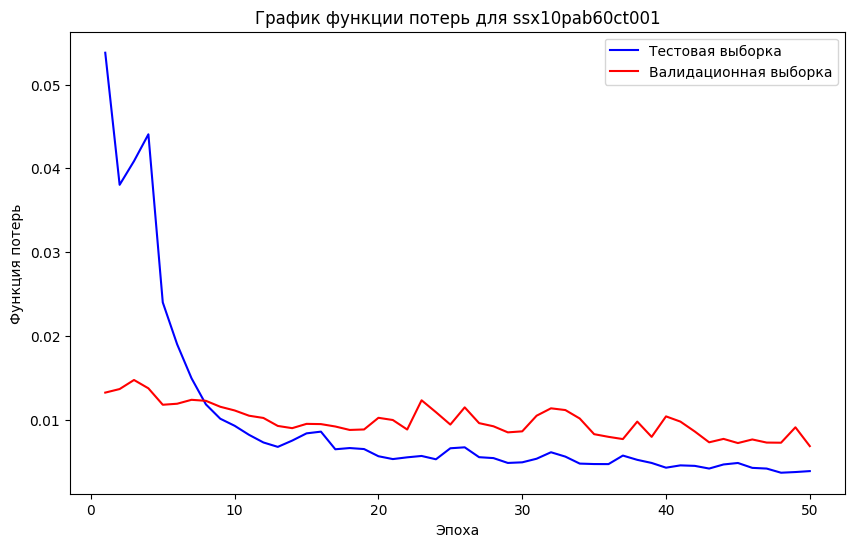

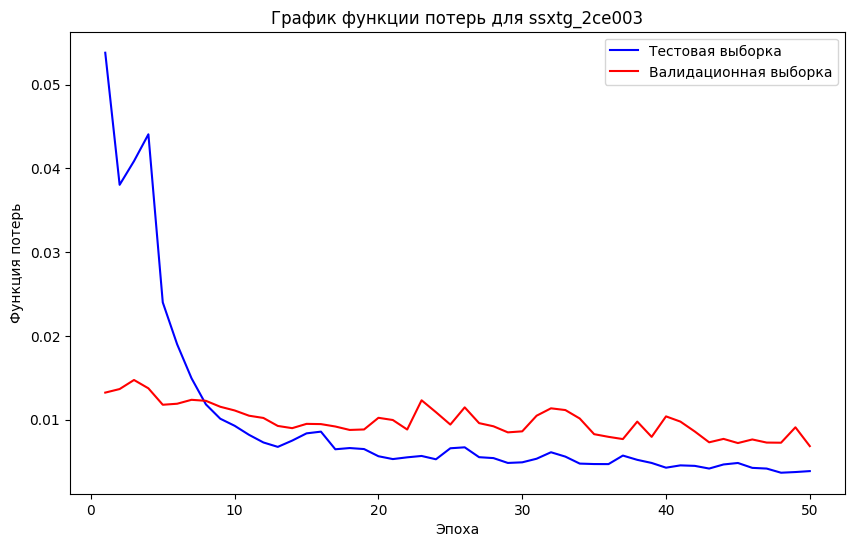

In [31]:
# Извлечение значений функций потерь из history
test_losses = history.history['loss']
validation_losses = history.history['val_loss']
epochs = range(1, len(test_losses) + 1)  # Список номеров эпох

# Создание словарей для каждой функции потерь по каждому сенсору
sensors_names = list(df)[:14]
test_losses_dict = {}
validation_losses_dict = {}
for i, sensor in enumerate(sensors_names):
    test_losses_dict[sensor] = test_losses
    validation_losses_dict[sensor] = validation_losses

# Построение графиков для каждого сенсора
for sensor in sensors_names:
    fig, ax = plt.subplots(figsize=(10, 6))

    # Строим графики для тестовой и валидационной выборок
    plt.plot(epochs, test_losses_dict[sensor], label='Тестовая выборка', color='blue')
    plt.plot(epochs, validation_losses_dict[sensor], label='Валидационная выборка', color='red')

    # Добавляем подписи осей и заголовок
    plt.xlabel('Эпоха')
    plt.ylabel('Функция потерь')
    plt.title(f'График функции потерь для {sensor}')

    # Добавляем легенду
    plt.legend()

    # Отображаем график
    plt.show()
 

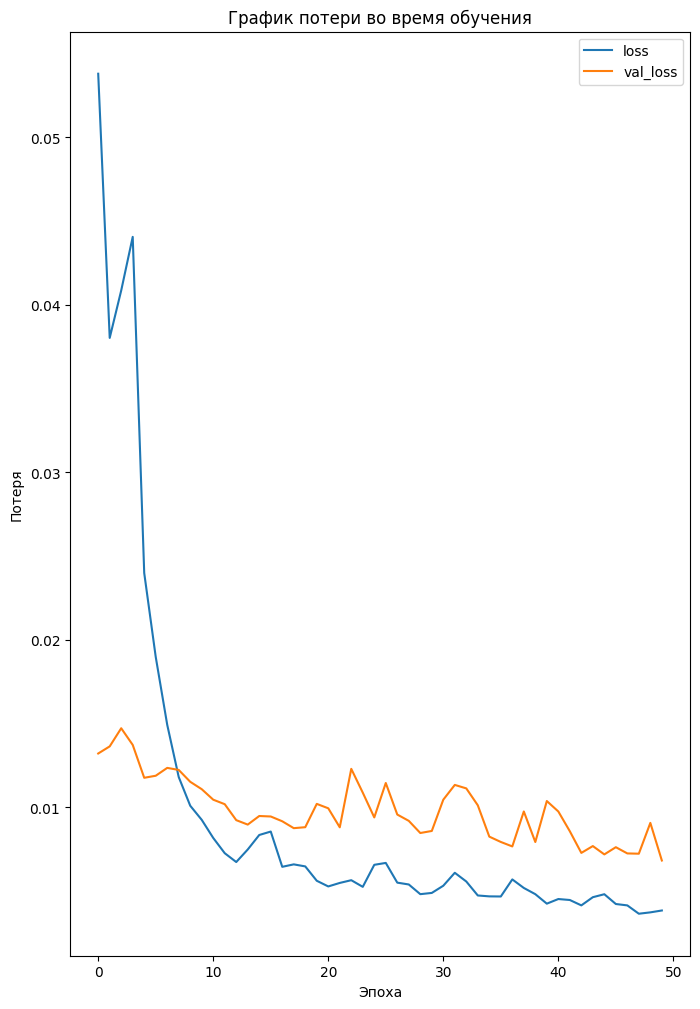

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Построение графика потери
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('График потери во время обучения')
plt.legend()
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_15220\2881016232.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


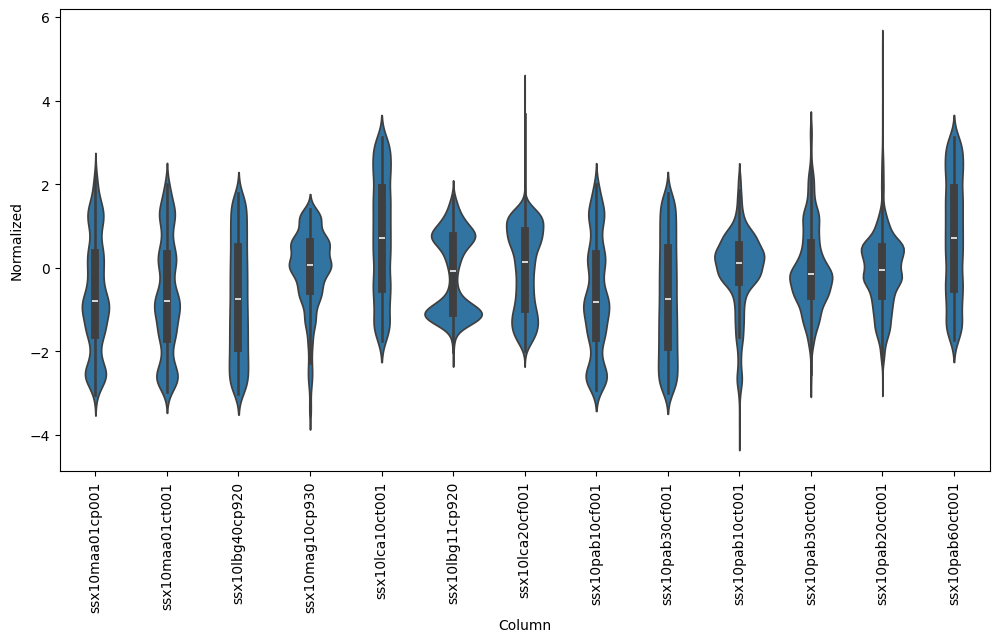

In [113]:
""" timestamp_s = date_time.map(pd.Timestamp.timestamp)
column_indices = {name: i for i, name in enumerate(df.columns)}

window_size = 10 
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()
#train_mean = train_df.rolling(window=window_size).mean()
#train_std = train_df.rolling(window=window_size).std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)
 """

In [134]:
""" class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}']) """

In [135]:
""" def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window """

In [136]:
""" def plot(self, model=None, plot_col='ssx10lbg11cp920', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 5 * len(self.label_columns)))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Время')

WindowGenerator.plot = plot

wide_window = WindowGenerator(
    input_width=10, label_width=10, shift=1,
    label_columns=['ssx10lbg11cp920'])

wide_window """

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 1  2  3  4  5  6  7  8  9 10]
Label column name(s): ['ssx10lbg11cp920']

In [137]:
""" def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset """

In [138]:
""" 
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example """

In [139]:
""" MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
  return history
 """

In [140]:
""" lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu',return_sequences= True),
    tf.keras.layers.Dropout(0.1),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)
val_performance = {}
performance = {} """

Input shape: (32, 10, 13)
Output shape: (32, 10, 1)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5767 - mean_absolute_error: 0.6481 - val_loss: 0.2402 - val_mean_absolute_error: 0.4022
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1110 - mean_absolute_error: 0.2331 - val_loss: 0.1094 - val_mean_absolute_error: 0.2636
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0483 - mean_absolute_error: 0.1507 - val_loss: 0.0625 - val_mean_absolute_error: 0.2050
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0234 - mean_absolute_error: 0.1124 - val_loss: 0.0412 - val_mean_absolute_error: 0.1663
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0156 - mean_absolute_error: 0.0970 - val_loss: 0.0351 - val_mean_absolute_error: 0.1522
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0119 - mean_absolute_error: 0.0840 - val_loss: 0.0360 - val_mean_absolute_error: 0.1448
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0109 - mean_absolute_error: 0.0810 -

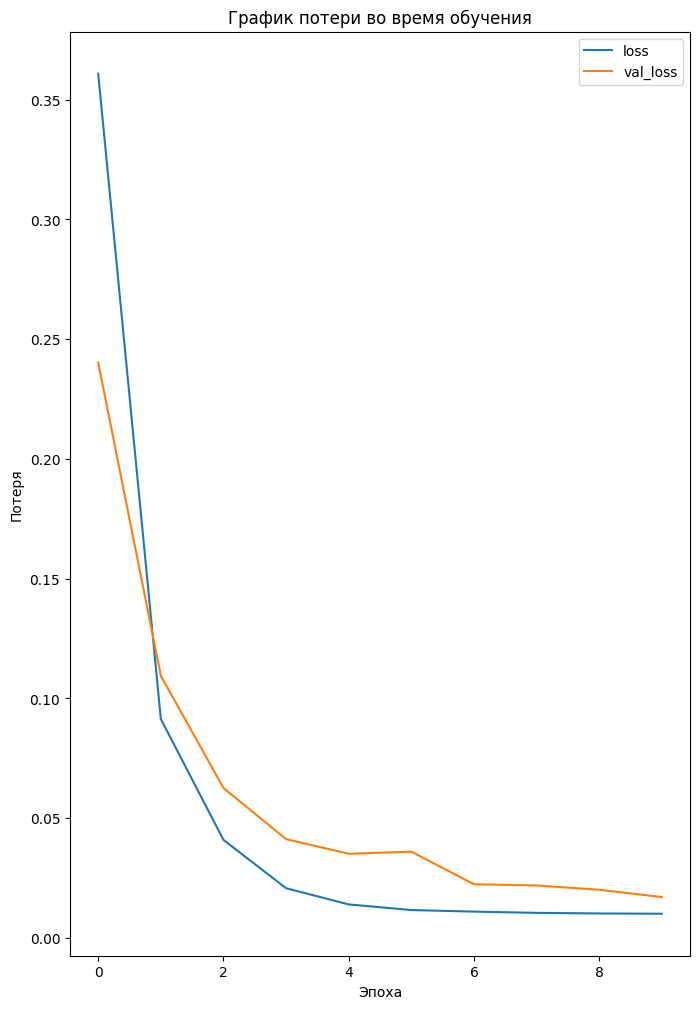

In [141]:
""" history = compile_and_fit(lstm_model, wide_window)



# Получение данных о потере и точности с истории обучения
loss = history.history['loss']
val_loss = history.history['val_loss']

# Построение графика потери
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('График потери во время обучения')
plt.legend()
plt.show()
 """

In [125]:
#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
val_loss, val_error = val_performance['LSTM']

performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
test_loss, test_error = performance['LSTM']

# Вывод результатов
print(f"Валидационная потеря: {val_loss}, Валидационная ошибка: {val_error}")
print(f"Тестовая потеря: {test_loss}, Тестовая ошибка: {test_error}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6080 - mean_absolute_error: 1.4060
Валидационная потеря: 2.6066508293151855, Валидационная ошибка: 1.404790997505188
Тестовая потеря: 3.888808488845825, Тестовая ошибка: 1.6410475969314575


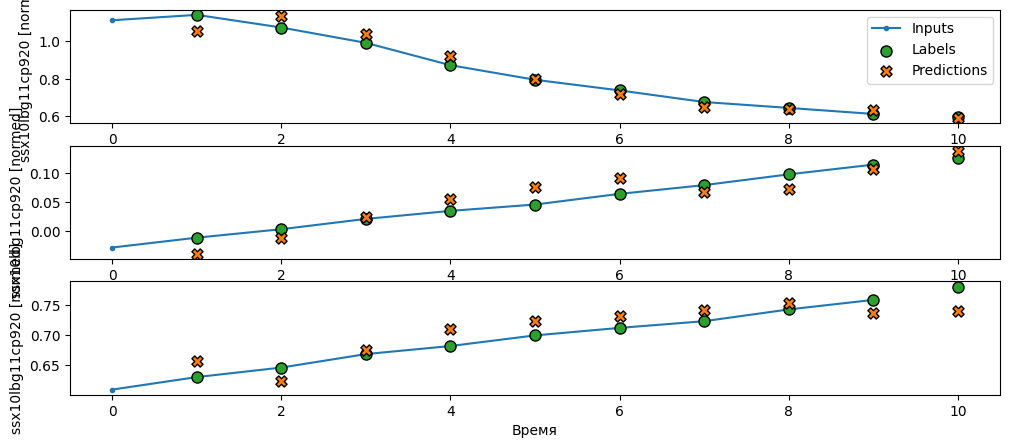

In [142]:

wide_window.plot(lstm_model)

 # Для каждого признака:

plt.show()